In [ ]:
# Manipulacion y Visualizacion de datos
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gp
from matplotlib.patches import Patch
from google.colab import drive
from PIL import Image

In [ ]:
!pip install 'dtreeviz'

In [ ]:
#Visualización
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, precision_recall_curve, roc_auc_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
propiedades = pd.read_csv('/content/dataframe_punto1.csv')
coordenadas_bsas = gp.read_file(r'./barrios.geojson.json')

# Clasificacion

## Construccion del Target

### Precio Por Metro Cuadrado

Comenzamos creando y calculando el precio por metro cuadrado de cada propiedad del dataset, variable que llamamos *pxm2*.

In [ ]:
pxm2 = []
for indice in propiedades.index:
  precio = propiedades.at[indice, 'precio']
  superficie = propiedades.at[indice, 'superficie_total']
  pxm2.append((precio / superficie).round(0))

propiedades['pxm2'] = pxm2
propiedades.sort_values('pxm2', inplace = True)
propiedades.reset_index(inplace = True, drop = True)

Y para ver como se distribuye, hacemos un BoxPlot.

<Axes: xlabel='pxm2'>

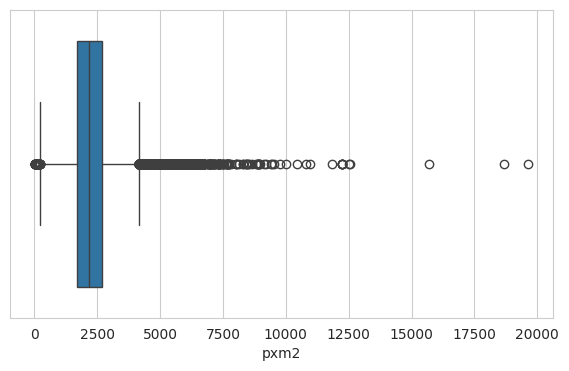

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(x='pxm2', data=propiedades)

Ademas, para ser mas precisos hacemos 3 BoxPlot, observando la distribucion de *pxm2* en base al *tipo* de la propiedad.

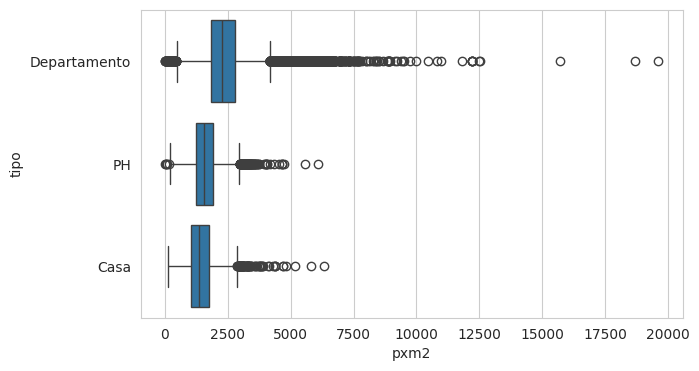

In [ ]:
plt.figure(figsize = (7,4))
sns.boxplot(y='tipo', x='pxm2', data=propiedades)
plt.show()

Observamos que el *pxm2* de los departamentos tienen los valores mas elevados, tanto en el rango intercuartilico, como en termino de outliers.

Otro detalle se observa en los outliers por debajo de la caja, que si bien en la distribucion general de la variable se distinguen algunos, en esta distribucion particular hay varios mas. Por otro lado, el *pxm2* de las casas es la unica distribucion que no tiene ningun outlier por debajo de la caja.

### Tipo Precio

Ahora creamos una variable discreta llamada *tipo_precio* que se va a obtener en base al *pxm2* de cada propiedad y va a tener tres valores posibles;

*   Bajo
*   Medio
*   Alto

Hay muchas formas en la cual podemos calcular esta variable; para empezar podemos hacerlo en base a la frecuencia relativa o los cuartiles de su distribucion, y a su vez podemos hacerlo o no por *tipo* de propiedad.

Estas opciones nos dejarian cuatro nuevas variables, y para dejar una sola vamos a crear y estudiar las cuatro.

Para crear la variable en base a la frecuencia relativa general, calculamos los umbrales del indice que dividen en tercios la tabla.

In [ ]:
tercio = propiedades.shape[0] / 3
segundo_tercio = 2*tercio

Obtenemos que cada tercio esta dado por un grupo de 24670 registros.

Ademas, para crear la variable en base al rango intercuartilico, calculamos el primer y el tercer cuartil.

In [ ]:
primer_cuartil = propiedades['pxm2'].quantile(q = 0.25)
tercer_cuartil = propiedades['pxm2'].quantile(q = 0.75)

print(f'{"Primer cuartil: "}{primer_cuartil}')
print(f'{"Tercer cuartil: "}{tercer_cuartil}')

Primer cuartil: 1707.0
Tercer cuartil: 2688.0


Con los datos ya calculados, imputamos en las nuevas variables dependiendo el umbral que superen.

In [ ]:
tp_frecuencia = []
tp_cuartil = []

for indice in propiedades.index:
  precioxm2 = propiedades.at[indice, 'pxm2']

  if indice < tercio - 1:
    tp_frecuencia.append('Bajo')
  elif indice  < segundo_tercio - 1:
    tp_frecuencia.append('Medio')
  else:
    tp_frecuencia.append('Alto')

  if precioxm2 < primer_cuartil:
    tp_cuartil.append('Bajo')
  elif precioxm2 > tercer_cuartil:
    tp_cuartil.append('Alto')
  else:
    tp_cuartil.append('Medio')

propiedades['tp_frecuencia'] = tp_frecuencia
propiedades['tp_cuartil'] = tp_cuartil
propiedades.sample(5)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,pxm2,tp_frecuencia,tp_cuartil
23749,UrKLexB6eTTvWCScDu4X0A==,2021-05-28,2021-06-05,-34.623720,-58.444557,Caballito,Departamento,3.0,2.0,75.0,60.0,139000.0,Departamento - Caballito Sur,1853.0,Bajo,Medio
27419,Q3GjwwlHWlpTOH97sO4AuA==,2021-12-16,2022-02-09,-34.594733,-58.400236,Recoleta,Departamento,4.0,3.0,185.0,170.0,360000.0,VENTA RECOLETA PISO 4 AMB DEP + 2 BALCONES,1946.0,Medio,Medio
29596,WtyC5Nflh+TY/RDbA2oJ8w==,2021-08-20,2022-01-27,-34.573738,-58.440683,Belgrano,Departamento,2.0,1.0,140.0,76.0,280000.0,Penthouse A Estrenar!,2000.0,Medio,Medio
27881,kU7i73YYmsD96Eh88QeWgA==,2021-03-12,2021-05-14,-34.613101,-58.467800,Villa General Mitre,Casa,5.0,4.0,240.0,240.0,470000.0,Venta casa 4 amb + dep + escritorio + 2 cocher...,1958.0,Medio,Medio
28198,i3/HeYxy7Sh8FmKxDDPbLg==,2021-12-16,2022-02-09,-34.590165,-58.400558,Recoleta,Departamento,3.0,2.0,122.0,103.0,240000.0,Venta de Semipiso en Barrio Norte,1967.0,Medio,Medio


Ahora creamos las variables en base a la frecuencia relativa y al rango intercuartilico, dependiendo del *tipo* de propiedad.

In [ ]:
propiedades['tp_frecuencia_tipo'] = np.nan
propiedades['tp_cuartil_tipo'] = np.nan

Para ello, volvemos a realizar los calculos de los umbrales anteriores, pero ahora en base a la variable.

In [ ]:
tercios_por_tipo = propiedades.groupby('tipo')['pxm2'].count().reset_index()
tercios_por_tipo.rename(columns = {'pxm2': 'cantidad'}, inplace = True)
tercios_por_tipo['primer_tercio'] = tercios_por_tipo['cantidad'] / 3
tercios_por_tipo['segundo_tercio'] = tercios_por_tipo['primer_tercio'] * 2
print(f'{""}{tercios_por_tipo}')

           tipo  cantidad  primer_tercio  segundo_tercio
0          Casa      3210    1070.000000     2140.000000
1  Departamento     63456   21152.000000    42304.000000
2            PH      7345    2448.333333     4896.666667


In [ ]:
primer_cuartil_por_tipo = propiedades.groupby('tipo')['pxm2'].quantile(q = 0.25).reset_index()
tercer_cuartil_por_tipo = propiedades.groupby('tipo')['pxm2'].quantile(q = 0.75).reset_index()

primer_cuartil_por_tipo.rename(columns = {'pxm2': 'primer_cuartil'}, inplace = True)
tercer_cuartil_por_tipo.rename(columns = {'pxm2': 'tercer_cuartil'}, inplace = True)

print(f'{""}{primer_cuartil_por_tipo}\n')
print(f'{""}{tercer_cuartil_por_tipo}')

           tipo  primer_cuartil
0          Casa         1021.25
1  Departamento         1849.00
2            PH         1222.00

           tipo  tercer_cuartil
0          Casa          1755.0
1  Departamento          2778.0
2            PH          1917.0


Para poder imputar los valores correspondientes a cada variable, dividimos el dataframe por tipo y ademas nos guardamos una copia de los indices, para poder imputar correctamente.

In [ ]:
indices = []

for indice in propiedades.index:
  indices.append(indice)

propiedades['indices'] = indices

In [ ]:
casas = propiedades[propiedades['tipo'] == 'Casa'].sort_values('pxm2').reset_index(drop = True)

In [ ]:
deptos = propiedades[propiedades['tipo'] == 'Departamento'].sort_values('pxm2').reset_index(drop = True)

In [ ]:
phs = propiedades[propiedades['tipo'] == 'PH'].sort_values('pxm2').reset_index(drop = True)

Una vez hechos todos los preparativos, imputamos ambas variables que correspondan a las propiedades que son casas. Cabe destacar que dentro de los dataframes donde guardamos los umbrales, las filas que representan las casas corresponden al indice 0 (se pueden observar en los primeros loc).

In [ ]:
primer_tercio = tercios_por_tipo.loc[0, 'primer_tercio']
segundo_tercio = tercios_por_tipo.loc[0, 'segundo_tercio']

primer_cuartil = primer_cuartil_por_tipo.loc[0, 'primer_cuartil']
tercer_cuartil = tercer_cuartil_por_tipo.loc[0, 'tercer_cuartil']

for indice in casas.index:
  id = casas.loc[indice, 'indices']
  precioxm2 = propiedades.at[indice, 'pxm2']

  if indice < primer_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Bajo'
  elif indice < segundo_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Medio'
  else:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Alto'

  if precioxm2 < primer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Bajo'
  elif precioxm2 > tercer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Alto'
  else:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Medio'

Ahora imputamos ambas variables que correspondan a las propiedades que son departamentos. Cabe destacar que dentro de los dataframes donde guardamos los umbrales, las filas que representan las casas corresponden al indice 1 (se pueden observar en los primeros loc).

In [ ]:
primer_tercio = tercios_por_tipo.loc[1, 'primer_tercio']
segundo_tercio = tercios_por_tipo.loc[1, 'segundo_tercio']

primer_cuartil = primer_cuartil_por_tipo.loc[1, 'primer_cuartil']
tercer_cuartil = tercer_cuartil_por_tipo.loc[1, 'tercer_cuartil']

for indice in deptos.index:
  id = deptos.loc[indice, 'indices']
  precioxm2 = propiedades.at[indice, 'pxm2']

  if indice < primer_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Bajo'
  elif indice < segundo_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Medio'
  else:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Alto'

  if precioxm2 < primer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Bajo'
  elif precioxm2 > tercer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Alto'
  else:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Medio'

Por ultimo imputamos ambas variables que correspondan a las propiedades que son PH. Cabe destacar que dentro de los dataframes donde guardamos los umbrales, las filas que representan las casas corresponden al indice 2 (se pueden observar en los primeros loc).

In [ ]:
primer_tercio = tercios_por_tipo.loc[2, 'primer_tercio']
segundo_tercio = tercios_por_tipo.loc[2, 'segundo_tercio']

primer_cuartil = primer_cuartil_por_tipo.loc[2, 'primer_cuartil']
tercer_cuartil = tercer_cuartil_por_tipo.loc[2, 'tercer_cuartil']

for indice in phs.index:
  id = phs.loc[indice, 'indices']
  precioxm2 = propiedades.at[indice, 'pxm2']

  if indice < primer_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Bajo'
  elif indice < segundo_tercio - 1:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Medio'
  else:
    propiedades.loc[id, 'tp_frecuencia_tipo'] = 'Alto'

  if precioxm2 < primer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Bajo'
  elif precioxm2 > tercer_cuartil:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Alto'
  else:
    propiedades.loc[id, 'tp_cuartil_tipo'] = 'Medio'

Observamos algunos ejemplos de las cuatro variables creadas.

In [ ]:
propiedades.drop('indices', axis = 'columns', inplace = True)
propiedades.sample(5)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,pxm2,tp_frecuencia,tp_cuartil,tp_frecuencia_tipo,tp_cuartil_tipo
28919,VXgikFcXqRmDAwJ76iEWbQ==,2021-04-10,2021-04-30,-34.615358,-58.412790,Almagro,Departamento,3.0,2.0,58.0,48.0,115000.0,Venta Departamento 3 Amb. en Almagro,1983.0,Medio,Medio,Bajo,Bajo
26544,j6eoKOZZJxrrtxtiS9czUQ==,2021-02-23,2021-03-08,-34.607595,-58.445750,Caballito,PH,5.0,3.0,182.0,155.0,350000.0,PH - Cid Campeador,1923.0,Medio,Medio,Alto,Bajo
61382,grNv3FN6CmveZ+CesQAizA==,2021-10-22,2021-11-04,-34.545442,-58.467466,Nuñez,Departamento,3.0,2.0,70.0,62.0,205000.0,Departamento - Nuñez,2929.0,Alto,Alto,Alto,Medio
36950,wA752oFwFDOjSrKEnzQh8A==,2021-06-18,2021-07-17,-34.560017,-58.473553,Coghlan,PH,3.0,2.0,73.0,63.0,159000.0,Venta PH 3 ambientes con patio Coghlan,2178.0,Medio,Medio,Alto,Medio
382,M/xZysGwcHJ+dIiPfGLIHg==,2021-12-16,2022-02-09,-34.641139,-58.428175,Parque Chacabuco,Casa,5.0,3.0,310.0,162.0,177000.0,Casa en Parque Chacabuco a reciclar,571.0,Bajo,Bajo,Bajo,Bajo


Y para definir con cual nos quedamos, realizamos un PiePlot por cada *tipo_precio* que creamos y comparamos su distribucion.

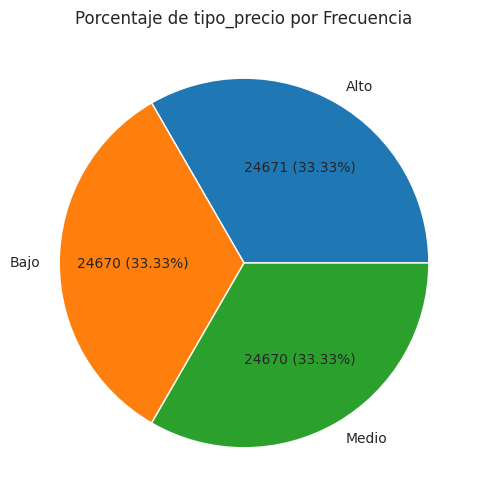

In [ ]:
precio_agrupado = propiedades.groupby('tp_frecuencia')['pxm2'].count().reset_index()
precio_agrupado.rename(columns = {'pxm2': 'cantidad'}, inplace = True)

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.pie(precio_agrupado['cantidad'], labels=['Alto', 'Bajo', 'Medio'], autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sum(precio_agrupado['cantidad']) / 100, p))
plt.title("Porcentaje de tipo_precio por Frecuencia")
plt.show()

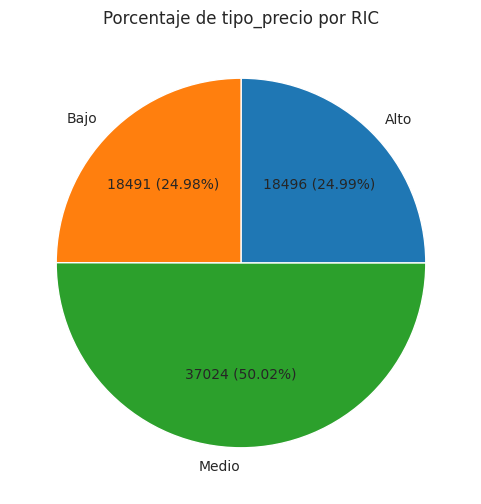

In [ ]:
precio_agrupado = propiedades.groupby('tp_cuartil')['pxm2'].count().reset_index()
precio_agrupado.rename(columns = {'pxm2': 'cantidad'}, inplace = True)

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.pie(precio_agrupado['cantidad'], labels=['Alto', 'Bajo', 'Medio'], autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sum(precio_agrupado['cantidad']) / 100, p))
plt.title("Porcentaje de tipo_precio por RIC")
plt.show()

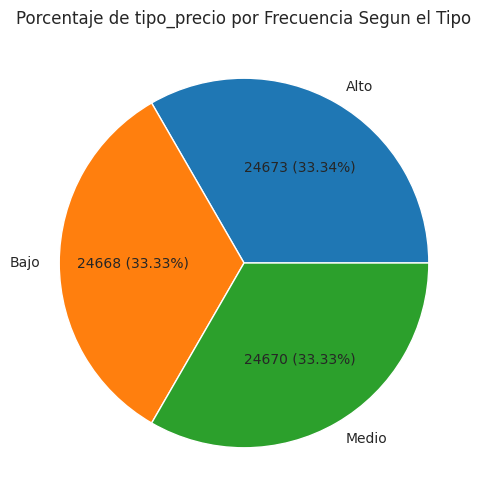

In [ ]:
precio_agrupado = propiedades.groupby('tp_frecuencia_tipo')['pxm2'].count().reset_index()
precio_agrupado.rename(columns = {'pxm2': 'cantidad'}, inplace = True)

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.pie(precio_agrupado['cantidad'], labels=['Alto', 'Bajo', 'Medio'], autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sum(precio_agrupado['cantidad']) / 100, p))
plt.title("Porcentaje de tipo_precio por Frecuencia Segun el Tipo")
plt.show()

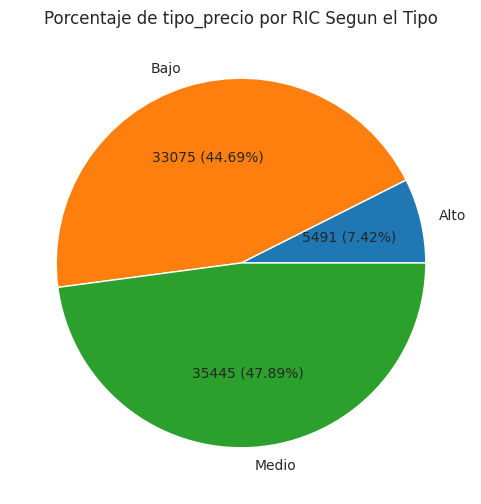

In [ ]:
precio_agrupado = propiedades.groupby('tp_cuartil_tipo')['pxm2'].count().reset_index()
precio_agrupado.rename(columns = {'pxm2': 'cantidad'}, inplace = True)
precio_agrupado

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
plt.pie(precio_agrupado['cantidad'], labels=['Alto', 'Bajo', 'Medio'], autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * sum(precio_agrupado['cantidad']) / 100, p))
plt.title("Porcentaje de tipo_precio por RIC Segun el Tipo")
plt.show()

Con estos graficos confirmamos lo que pensabamos cuando creamos las variables;

*   *tipo_precio* por frecuencia: Al dividir el *pxm2* en 3 partes iguales, la distribucion es 33,33% para todos los valores de la variable.
*   *tipo_precio* por RIC: Al dividir el *pxm2* por el RIC, los porcentajes quedan datos este rango, es decir, 25%, 50%, y 25% en ese orden para todos los valores de la variable.
*   *tipo_precio* por frecuencia segun el *tipo*: Al dividir cada *pxm2* en 3 partes iguales, incluso teniendo en cuenta el *tipo* de propiedad, la distribucion sigue siendo de 33,33% para todos los valores de la variable.
*   *tipo_precio* por RIC segun el *tipo*: Al tener en cuenta el *tipo* para dividir por el RIC, como las ditribuciones segun el *tipo* son diferentes, en esta variable cambian las proporciones comparadas con el resto. Por esta razon, las propiedades con un *tipo_precio* Alto son solo el 7,42%, el menor porcentaje de entre todas las variables.

Lo que podemos observar de las 4 distribuciones es que, en lo que mas se diferencian, es en la cantidad de propiedades con tipo_precio Alto. Por esta razon, vamos a comparar la distribucion de estas propiedades en las cuatro variables.

<Axes: title={'center': 'tipo_precio Alto por Frecuencia'}, xlabel='pxm2'>

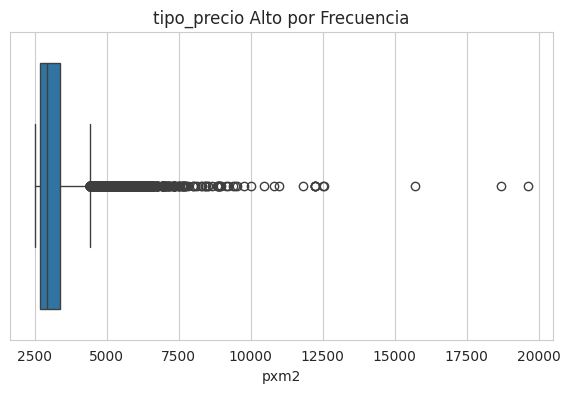

In [ ]:
propiedades_caras = propiedades[propiedades['tp_frecuencia'] == 'Alto']
plt.figure(figsize=(7,4))
plt.title("tipo_precio Alto por Frecuencia")
sns.boxplot(x='pxm2', data=propiedades_caras)

<Axes: title={'center': 'tipo_precio Alto por RIC'}, xlabel='pxm2'>

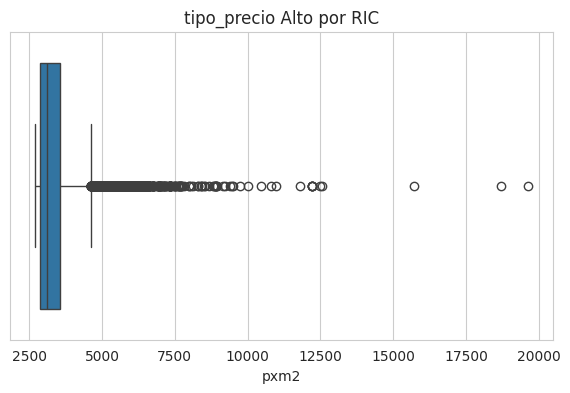

In [ ]:
propiedades_caras = propiedades[propiedades['tp_cuartil'] == 'Alto']
plt.figure(figsize=(7,4))
plt.title("tipo_precio Alto por RIC")
sns.boxplot(x='pxm2', data=propiedades_caras)

<Axes: title={'center': 'tipo_precio Alto por Frecuencia Segun el Tipo'}, xlabel='pxm2'>

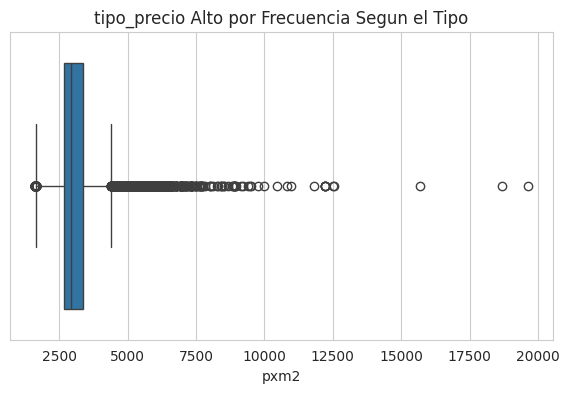

In [ ]:
propiedades_caras = propiedades[propiedades['tp_frecuencia_tipo'] == 'Alto']
plt.figure(figsize=(7,4))
plt.title("tipo_precio Alto por Frecuencia Segun el Tipo")
sns.boxplot(x='pxm2', data=propiedades_caras)

<Axes: title={'center': 'tipo_precio Alto por RIC Segun el Tipo'}, xlabel='pxm2'>

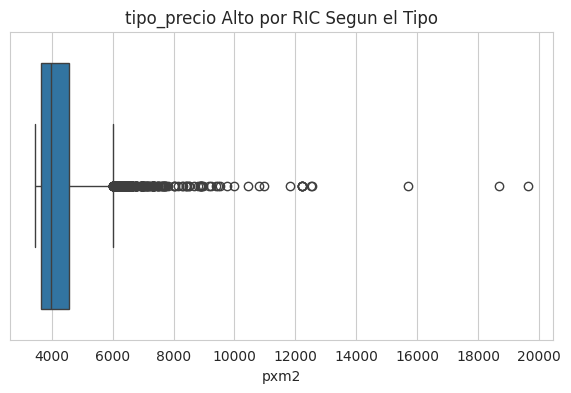

In [ ]:
propiedades_caras = propiedades[propiedades['tp_cuartil_tipo'] == 'Alto']
plt.figure(figsize=(7,4))
plt.title("tipo_precio Alto por RIC Segun el Tipo")
sns.boxplot(x='pxm2', data=propiedades_caras)

Observamos y concluimos que la variable que mejor clasifica el *pxm2* es el *tipo_precio* por RIC segun el tipo, que ademas es la variable que tiene los *pxm2* mas altos. Como es la que mejor clasifica estos precios, eligimos que esta sea nuestro *tipo_precio*.

Con esta decision en cuenta, eliminamos los demas tipo_precio creados y nos quedamos con la variable elegida.

In [ ]:
columnas_a_eliminar = ['tp_frecuencia', 'tp_cuartil', 'tp_frecuencia_tipo']
propiedades.drop(columnas_a_eliminar, axis = 'columns', inplace = True)
propiedades.rename(columns = {'tp_cuartil_tipo': 'tipo_precio'}, inplace = True)
propiedades.sample(5)

,id,fecha_inicio,fecha_fin,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,nombre,pxm2,tipo_precio
53887,iF2aYdwUQQZ6pFDERNN9oQ==,2021-09-17,2022-01-27,-34.597194,-58.404912,Recoleta,Departamento,1.0,1.0,37.0,33.0,97455.0,Departamento - Barrio Norte - Monoambiente - E...,2634.0,Medio
47271,4HY4b3iC3sgufBMnfTIIkg==,2021-12-08,2022-01-27,-34.597261,-58.414548,Palermo,Departamento,2.0,1.0,41.0,36.0,100000.0,"Amplio departamento en piso alto, ambiente y m...",2439.0,Medio
62425,k5YDF+nPHSfW0mC1N1rkvA==,2021-11-23,2022-01-27,-34.591076,-58.413615,Recoleta,Departamento,3.0,2.0,67.0,63.0,200000.0,Departamento 3 Amb. en Venta - Recoleta,2985.0,Medio
8737,jFo+osVqsGZx0VvAwoJtwQ==,2021-12-16,2022-02-09,-34.661377,-58.509374,Mataderos,PH,4.0,3.0,93.0,49.0,125900.0,"VENTA PH 4 AMB EN DOS PLANTAS, TERRAZA, MATADEROS",1354.0,Bajo
41711,6lljhK0/8AX59DNoVVicXQ==,2021-09-29,2022-01-27,-34.554763,-58.450241,Belgrano,Departamento,1.0,1.0,32.0,28.0,73500.0,Monoambiente en Belgrano,2297.0,Medio


### K-means vs tipo_precio

Para completar el analisis de la variable *tipo_precio*, comparamos su distribucion contra los grupos formados por el algortimo de K-means, mas especificamente contra K3.

Primero vamos a comparar como se distribuyen ambas clasificaciones sobre el mapa de CABA.

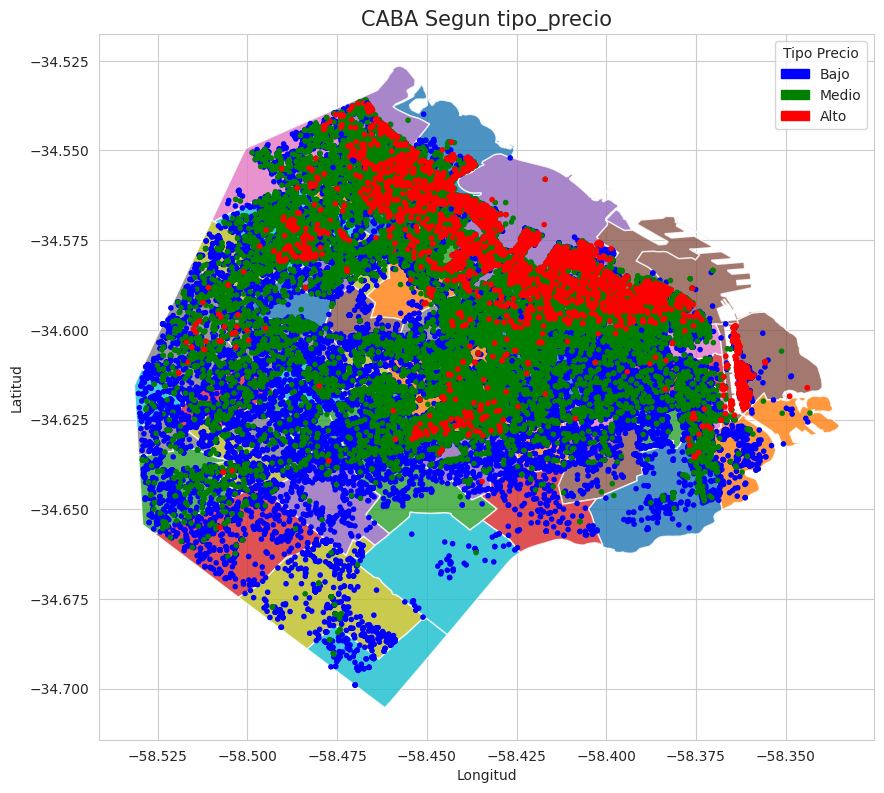

In [ ]:
color_map = {'Bajo': 'blue', 'Medio': 'green', 'Alto': 'red'}
colores = propiedades['tipo_precio'].map(color_map)

points = propiedades[['longitud','latitud']]
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.longitud, points.latitud))

fx, ax = plt.subplots(figsize=(10,10))
coordenadas_bsas.plot(ax=ax, column='BARRIO', alpha=0.8)
points.plot(ax=ax, c=colores, marker='.', label = 'tipo_precio')

legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Bajo'),
                   Patch(facecolor='green', edgecolor='green', label='Medio'),
                   Patch(facecolor='red', edgecolor='red', label='Alto')]
ax.legend(handles=legend_elements, title='Tipo Precio', loc='upper right')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

plt.title('CABA Segun tipo_precio', fontsize = 15)

plt.savefig('caba_tipo_precio.png', bbox_inches = 'tight')
plt.show()

Si alguien quiere descargar el grafico localmente, ejecute las siguientes lineas en un bloque de codigo abajo de este texto.
```
from google.colab import files
files.download('caba_tipo_precio.png')
```

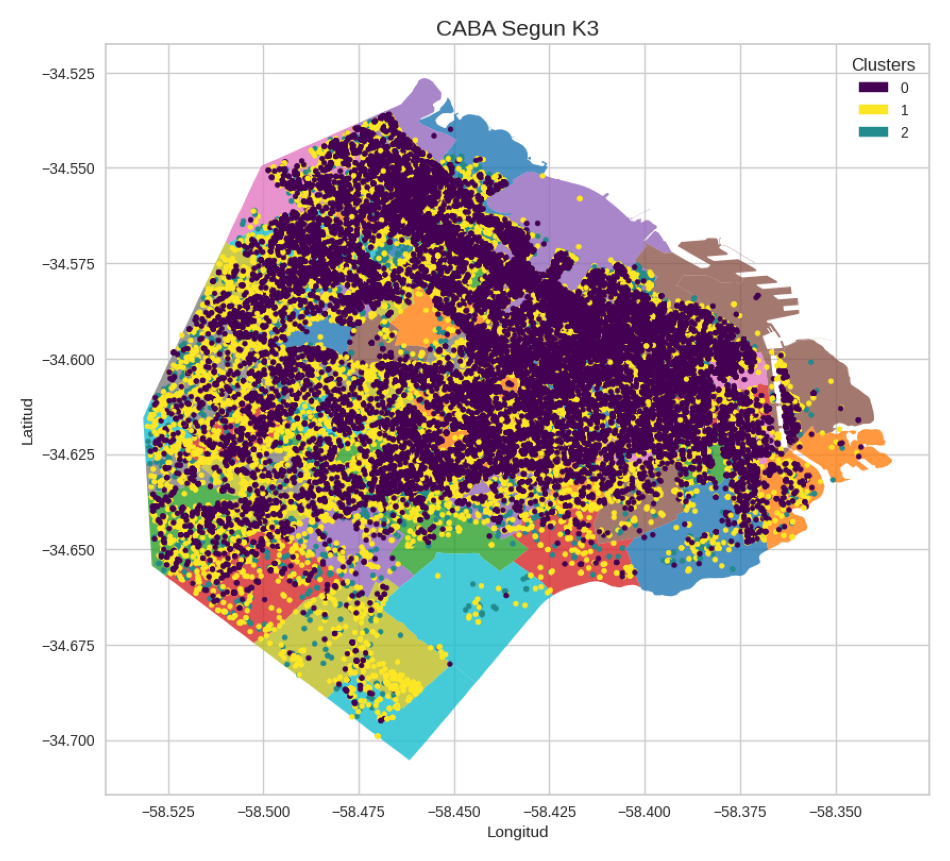

In [ ]:
img = Image.open('caba_k3.png')

plt.figure(figsize=(12, 12))
plt.axis('off')

plt.imshow(img)

Por como se distribuye K3 en el mapa de CABA, podemos inferir que la mayoria de propiedades con *tipo_precio*: <font color='red'>Alto</font>  forman parte del <font color='#FDE726'>cluster 0</font> o del <font color='violet'>cluster 1</font>, lo cual tiene sentido ya que estas propiedades son la minoria dentro de la variable, y estos dos clusters son la mayoria.

Y ahora vamos a comparar como se distribuyen ambas clasificaciones en un ScatterPlot de ejes *ambientes* y *superficie_total*, debido a que son las variables que forman los clusters en K-means.

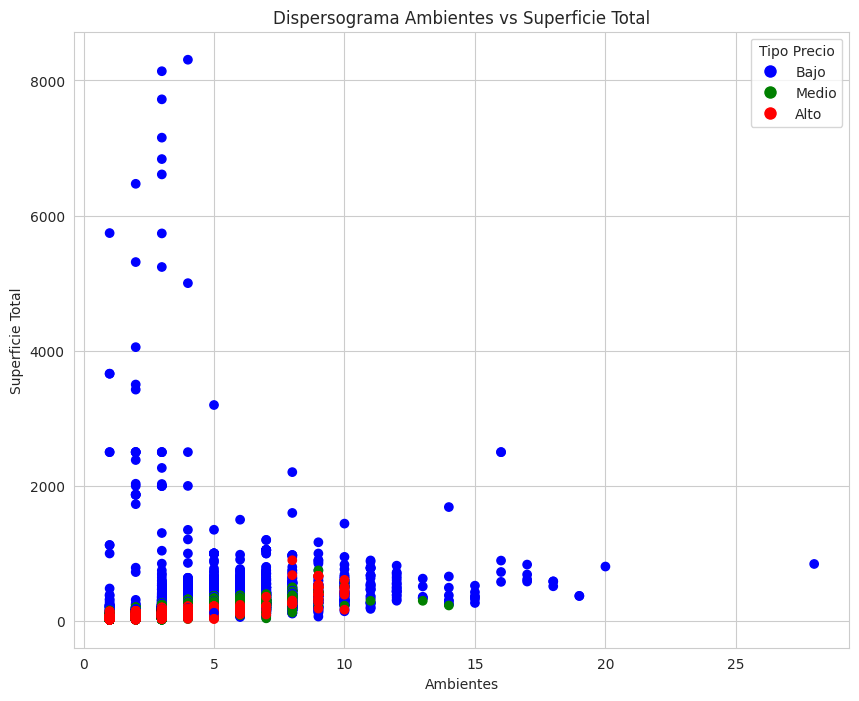

In [ ]:
color_map = {'Bajo': 'blue', 'Medio': 'green', 'Alto': 'red'}
colores = propiedades['tipo_precio'].map(color_map)

plt.figure(figsize=(10, 8))
plt.scatter(propiedades['ambientes'], propiedades['superficie_total'], c = colores)
plt.title("Dispersograma Ambientes vs Superficie Total")

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Bajo'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Medio'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Alto')]
plt.legend(handles=legend_elements, title='Tipo Precio', loc='upper right')

plt.xlabel("Ambientes")
plt.ylabel("Superficie Total")

plt.show()

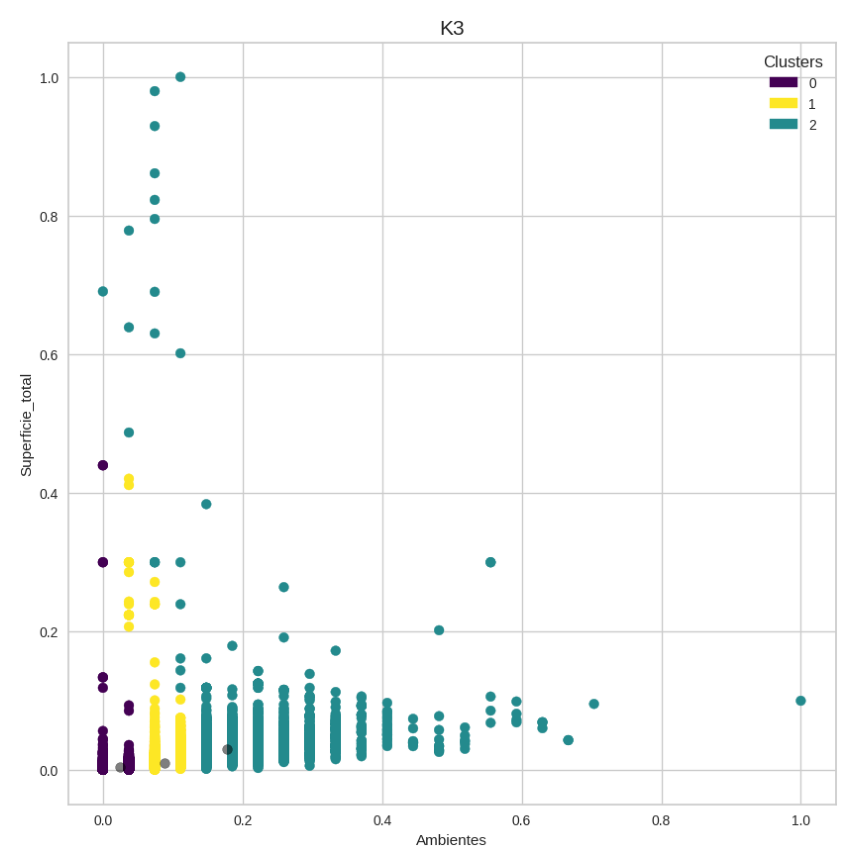

In [ ]:
img = Image.open('k3.png')

plt.figure(figsize=(11, 11))
plt.axis('off')

plt.imshow(img)

Lamentablemente, no podemos concluir ninguna relacion entre los clusters formados y la clasificacion obtenida por la variable *tipo_precio*.

## Entrenamiento y Prediccion

Ahora con la variable *tipo_precio* creada, entrenamos 3 modelos disintos para intentar predecirla.

### Arboles de Decision

Para predecir la variable *tipo_precio* con Arboles de Decision, ejecutamos el siguiente algoritmo:

1.   Realizamos un preprocesamiento inicial sobre el dataframe.
2.   Dividimos el dataframe en train-test, creamos el modelo y lo entrenamos.
3.   Mostramos las metricas, la matriz de confusion, y la importancia de sus variables.
4.   Graficamos el arbol o una porción representativa del mismo, en caso de ser muy grande.

#### Arbol de Decision Basico

##### Preprocesamiento

Primero, eliminamos varias columnas que consideramos irrelevantes o en su defecto, tienen información directamente relacionada a *tipo_precio*.

In [ ]:
columnas_eliminar = ['precio', 'pxm2', 'id', 'fecha_inicio', 'fecha_fin', 'latitud', 'longitud', 'nombre']
propiedades_arbol = propiedades.drop(columnas_eliminar, axis='columns', inplace=False)

propiedades_arbol.columns.tolist()

['barrio',
 'tipo',
 'ambientes',
 'dormitorios',
 'superficie_total',
 'superficie_cubierta',
 'tipo_precio']

Y antes de entrenar el modelo, debemos reconvertir las variables categoricas en numeros.

Primero modificamos el target (la variable a predecir) para que quede en una sola columna pero con valores numericos.

In [ ]:
propiedades_arbol.replace(to_replace = {'Bajo' : 0, 'Medio' : 1, 'Alto' : 2}, inplace = True)

Y para las otras dos variables categoricas, las transformamos mediante un one hot encoding. Al metodo `get_dummies` podemos pasarle como parámetro `drop_first = True`, ya que la categoría eliminada se la puede deducir por complemento (es decir, si yo tengo una propiedad que NO es PH ni Departamento, se deduce que será una Casa).

Sin embargo, como este será un Arbol Basico sin optimizaciones, por ahora no le pasaremos ese parametro, que por default, sera un False.

In [ ]:
propiedades_arbol = pd.get_dummies(propiedades_arbol, columns=['barrio', 'tipo'], dtype = int, drop_first=False)

##### Division Train-Test

Realizamos las divisiones con las cuales vamos a entrenar.

In [ ]:
propiedades_dtc_x = propiedades_arbol.drop(['tipo_precio'], axis = 'columns', inplace = False)

propiedades_dtc_y = propiedades_arbol['tipo_precio'].copy()

x_train, x_test, y_train, y_test = train_test_split(propiedades_dtc_x,
                                                    propiedades_dtc_y,
                                                    test_size = 0.2,
                                                    random_state = 2)

Ahora si creamos y entrenamos el modelo sin elegir hiperparametros, es decir, un Arbol totalmente por default (salvo por el `random_state` para eliminarle la aleatoriedad entre ejecuciones).

In [ ]:
tree_model = tree.DecisionTreeClassifier(random_state = 2)

modelo = tree_model.fit(X = x_train, y = y_train)

Y observamos como predice el modelo entrenado.

In [ ]:
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test', 'pred'])
resultados.head(10)

,test,pred
0,1,0
1,1,0
2,0,0
3,1,1
4,0,0
5,0,1
6,1,0
7,0,0
8,1,2
9,0,0


##### Metricas y Matriz de Confusion

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

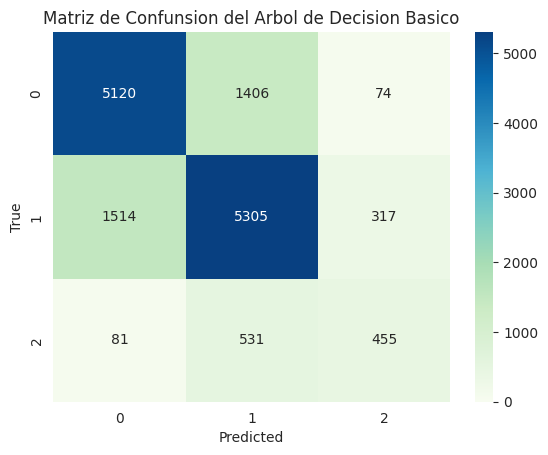

In [ ]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Arbol de Decision Basico')

plt.show()

Y para respaldar el grafico, calculamos las metricas en el conjunto de evaluacion.

Sin embargo, como el dato a predecir es multiclase y no es binario, las metricas necesitan saber como calcularse cuando hay mas de dos clases en los datos.

Investigamos en la correspondiente documentacion las opciones disponibles para el parametro `average`, y algunas posibilidades para el parametro son:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7349861514557859
Recall: 0.7349861514557859
Precision: 0.7318466938795161
f1 score: 0.7329077069125038


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6600
           1       0.73      0.74      0.74      7136
           2       0.54      0.43      0.48      1067

    accuracy                           0.73     14803
   macro avg       0.68      0.65      0.66     14803
weighted avg       0.73      0.73      0.73     14803



Y ademas medimos importancia de las variables, que se calcula como la reduccion total (normalizada) del criterio aportado por esa caracteristica, tambien conocido como **Gini Importance** o  **Mean Decrease in Impurity** (MDI).

In [ ]:
sorted(list(zip(propiedades_dtc_x.columns.to_list(), modelo.feature_importances_)), key=lambda x: -x[1])

[('superficie_total', 0.29157940763328516),
 ('superficie_cubierta', 0.2691968458215883),
 ('tipo_Departamento', 0.13212358562114876),
 ('ambientes', 0.05012408399787053),
 ('barrio_Balvanera', 0.02861065803037792),
 ('dormitorios', 0.0285083159620669),
 ('barrio_Palermo', 0.024975878132313417),
 ('barrio_Recoleta', 0.022166384026273318),
 ('barrio_Puerto Madero', 0.01976315684428954),
 ('barrio_Belgrano', 0.019194849105244126),
 ('barrio_Villa Urquiza', 0.01172499254362971),
 ('barrio_Nuñez', 0.010983954633254644),
 ('barrio_Colegiales', 0.00930013939650167),
 ('barrio_Caballito', 0.0086547893195495),
 ('barrio_Villa Crespo', 0.004688351377727488),
 ('barrio_Saavedra', 0.00466247210150258),
 ('barrio_Coghlan', 0.004490644213464117),
 ('barrio_Villa Devoto', 0.003990898705740167),
 ('barrio_Retiro', 0.00321038343219335),
 ('barrio_Almagro', 0.003131949448778418),
 ('barrio_Villa del Parque', 0.003099271037033145),
 ('barrio_Chacarita', 0.002574282848482475),
 ('barrio_San Telmo', 0.002

Con este array de **Gini Importance**, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de *superficie_total* y *superficie_cubierta*
2.   Si la propiedad es un Departamento
3.   Su cantidad de *ambientes*
4.   Si la propiedad es del *barrio* Balvanera
5.   Su cantidad de *dormitorios*

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

##### Grafico del Arbol

Para terminar, graficamos el Arbol obtenido. Cabe destacar que, por la cantidad de registros, el Arbol completo tarda demasiado en correr y ademas no se visualiza bien, por lo que solo graficamos una parte.

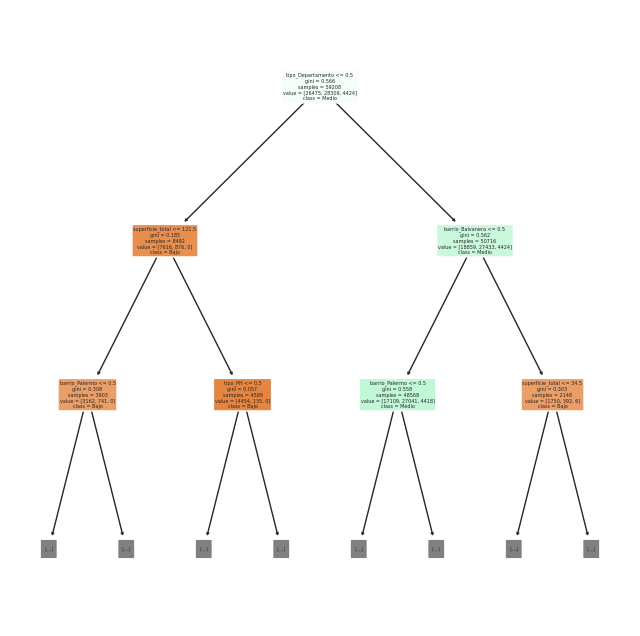

In [ ]:
plt.figure(figsize = (8,8))

tree_plot = tree.plot_tree(modelo,
                           max_depth = 2,
                           feature_names = propiedades_dtc_x.columns.to_list(),
                           filled = True,
                           rounded = True,
                           class_names = ['Bajo', 'Medio', 'Alto'])

plt.show(tree_plot)

#### Validacion Cruzada

Ya con el Arbol default entrenado, buscamos los mejores hiperparametros con **Random Search Cross Validation**.

Sin embargo, antes de realizar el **Random Search CV** tendremos que hacer los mismos procedimientos que antes, es decir, el preprocesamiento y la division train-test.

##### Preprocesamiento

Igual que antes, eliminamos varias columnas que consideramos irrelevantes o en su defecto, tienen información directamente relacionada a *tipo_precio*.

In [ ]:
columnas_eliminar = ['precio', 'pxm2', 'id', 'fecha_inicio', 'fecha_fin', 'latitud', 'longitud', 'nombre']
propiedades_arbol_hp = propiedades.drop(columnas_eliminar, axis = 'columns', inplace = False)

propiedades_arbol_hp.columns.tolist()

['barrio',
 'tipo',
 'ambientes',
 'dormitorios',
 'superficie_total',
 'superficie_cubierta',
 'tipo_precio']

Y antes de entrenar el modelo, debemos reconvertir las variables categoricas en numeros.

Primero modificamos el target (la variable a predecir) para que quede en una sola columna pero con valores numericos.

In [ ]:
propiedades_arbol_hp.replace(to_replace = {'Bajo' : 0, 'Medio' : 1, 'Alto' : 2}, inplace = True)

Y para las otras dos variables categoricas, las transformamos mediante un one hot encoding. Pero esta vez, al metodo `get_dummies` le pasamos como parámetro `drop_first = True`.

In [ ]:
propiedades_arbol_hp = pd.get_dummies(propiedades_arbol_hp, columns=['barrio', 'tipo'], dtype = int, drop_first=True)

##### Division Train-Test

Realizamos las divisiones con las cuales vamos a buscar los hiperparametros.

In [ ]:
propiedades_hp_x = propiedades_arbol_hp.drop(['tipo_precio'], axis = 'columns', inplace = False)

propiedades_hp_y = propiedades_arbol_hp['tipo_precio'].copy()

x_train, x_test, y_train, y_test = train_test_split(propiedades_hp_x,
                                                    propiedades_hp_y,
                                                    test_size=0.2,
                                                    random_state=2)

##### Randomized Search CV

Exploramos un espacio de busqueda, usando k-fold CV para medir el desempeño de cada combinacion. Al terminar, nos quedamos con la combinacion con mejor desempeño y entrenamos un unico modelo usando todos los datos de train. La metrica seleccionada a mejorar para buscar hiperparametros optimizados es el F1 Score.

Cabe destacar que en la siguiente parte del codigo;
```
params_grid = {'criterion' : ['gini', 'entropy'],
               'min_samples_leaf' : list(range(2, 20)),
               'max_depth' : list(range(1, 25))}
```
podriamos intentamos agregando otros parametros pero de esta forma obtuvimos mejores resultados. Los parametros intentamos agregar son:

```
'min_samples_split' : list(range(2, 20))
'ccp_alpha' : np.linspace(0, 0.05, n)
```






In [ ]:
#Cantidad de combinaciones que quiero probar
combinaciones = 40

#Cantidad de splits para el Cross Validation
folds = 20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion' : ['gini', 'entropy'],
               'min_samples_leaf' : list(range(2, 20)),
               'max_depth' : list(range(1, 25))}

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits = folds)

#Clasificador
arbol = DecisionTreeClassifier()

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average = 'weighted')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = arbol,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = combinaciones)

#Busco los hiperparametros que optimizan F1 Score
randomcv.fit(x_train, y_train);

In [ ]:
print(f'{"Score: "}{randomcv.best_score_}')
parametros = randomcv.best_params_
parametros

Score: 0.7210970155081807


{'min_samples_leaf': 7, 'max_depth': 20, 'criterion': 'entropy'}

Visualizamos los resultados obtenidos en un dataframe.

In [ ]:
pd.DataFrame(randomcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
0,0.077879,0.005782,0.003842,0.000500,5,3,gini,"{'min_samples_leaf': 5, 'max_depth': 3, 'crite...",0.571599,0.562160,...,0.567654,0.551347,0.568329,0.574670,0.551366,0.544020,0.558542,0.560864,0.009889,38
1,0.229676,0.037030,0.004517,0.000855,9,13,entropy,"{'min_samples_leaf': 9, 'max_depth': 13, 'crit...",0.711568,0.707390,...,0.714082,0.706970,0.706724,0.697671,0.695387,0.699901,0.705895,0.702129,0.007183,20
2,0.255103,0.007342,0.004238,0.000449,13,19,gini,"{'min_samples_leaf': 13, 'max_depth': 19, 'cri...",0.724856,0.724311,...,0.724809,0.723457,0.721468,0.709647,0.719519,0.721671,0.717522,0.719424,0.005462,9
3,0.304367,0.048781,0.004601,0.000673,3,23,gini,"{'min_samples_leaf': 3, 'max_depth': 23, 'crit...",0.724593,0.720396,...,0.731967,0.728894,0.720654,0.704941,0.717990,0.724922,0.710928,0.718442,0.007778,11
4,0.242731,0.009166,0.004101,0.000453,16,18,gini,"{'min_samples_leaf': 16, 'max_depth': 18, 'cri...",0.722999,0.722377,...,0.718689,0.730727,0.723744,0.708446,0.714638,0.717433,0.717676,0.716185,0.006336,15
5,0.289177,0.049525,0.004591,0.001126,18,24,gini,"{'min_samples_leaf': 18, 'max_depth': 24, 'cri...",0.723698,0.724946,...,0.730701,0.728874,0.727768,0.717316,0.719647,0.720811,0.722438,0.720775,0.005692,5
6,0.246863,0.008423,0.004137,0.000319,6,18,gini,"{'min_samples_leaf': 6, 'max_depth': 18, 'crit...",0.724932,0.725955,...,0.722038,0.729438,0.721395,0.704569,0.718867,0.714433,0.720906,0.717673,0.006124,12
7,0.037771,0.001457,0.003626,0.000189,8,1,entropy,"{'min_samples_leaf': 8, 'max_depth': 1, 'crite...",0.537876,0.534882,...,0.540741,0.521015,0.521730,0.539341,0.521635,0.515331,0.528372,0.526673,0.009577,39
8,0.265584,0.044218,0.004711,0.001084,10,18,entropy,"{'min_samples_leaf': 10, 'max_depth': 18, 'cri...",0.722767,0.723876,...,0.730859,0.721111,0.717015,0.705258,0.719639,0.715705,0.723077,0.717471,0.007265,13
9,0.194400,0.006266,0.003916,0.000173,13,12,entropy,"{'min_samples_leaf': 13, 'max_depth': 12, 'cri...",0.705759,0.692184,...,0.708681,0.698796,0.694766,0.693599,0.686782,0.691449,0.694512,0.692468,0.007475,24


Con el F1-Score obtenido, buscamos la importancia de features.

In [ ]:
best_tree = randomcv.best_estimator_
importancias = best_tree.feature_importances_

importancias_list = list(zip(importancias, propiedades_dtc_x.columns.to_list()))
importancias_list.sort(reverse=True)

for feat_imp, feat in importancias_list:
    if feat_imp >= 0:
        print('{}: {}'.format(feat, feat_imp))

superficie_total: 0.24859519995104437
barrio_Villa del Parque: 0.186666694846816
superficie_cubierta: 0.18040288084878528
barrio_Nuñez: 0.061371716736878024
barrio_Pompeya: 0.04793897286564117
barrio_Barracas: 0.0464829878135627
barrio_Puerto Madero: 0.04438154426329585
ambientes: 0.03576377195077297
barrio_Monte Castro: 0.024445692021680867
barrio_Almagro: 0.01776696488786118
barrio_Villa Soldati: 0.01562232582896405
dormitorios: 0.015314082613391356
tipo_Casa: 0.013756421120192121
barrio_Boedo: 0.012565649017907582
barrio_Coghlan: 0.010872053018508052
barrio_Retiro: 0.005868632333436995
barrio_Chacarita: 0.005580049081214758
barrio_Versalles: 0.005097594572114258
barrio_Villa Crespo: 0.005055414866838695
barrio_Recoleta: 0.0042976258348263385
barrio_Agronomía: 0.0034188615450920176
barrio_Catalinas: 0.0031512893397238405
barrio_Villa Ortuzar: 0.0017977798086864563
barrio_Villa Urquiza: 0.0016603374432271726
barrio_San Nicolás: 0.0010606096515028618
barrio_Saavedra: 0.0003325155683337

#### Arbol de Decision con Hiperparametros

##### Preprocesamiento

Otra vez, eliminamos varias columnas que consideramos irrelevantes o en su defecto, tienen información directamente relacionada a tipo_precio.

In [ ]:
columnas_eliminar = ['precio', 'pxm2', 'id', 'fecha_inicio', 'fecha_fin', 'latitud', 'longitud', 'nombre']
propiedades_arbol_optimizado = propiedades.drop(columnas_eliminar, axis='columns', inplace = False)

propiedades_arbol_optimizado.columns.tolist()

['barrio',
 'tipo',
 'ambientes',
 'dormitorios',
 'superficie_total',
 'superficie_cubierta',
 'tipo_precio']

Y antes de entrenar el modelo, debemos reconvertir las variables categoricas en numeros.

Primero modificamos el target (la variable a predecir) para que quede en una sola columna pero con valores numericos.

In [ ]:
propiedades_arbol_optimizado.replace(to_replace = {'Bajo' : 0, 'Medio':  1, 'Alto' : 2}, inplace = True)

Y para las otras dos variables categoricas, las transformamos mediante un one hot encoding. Y como ya hicimos, al metodo `get_dummies` le pasamos como parámetro `drop_first = True`.

In [ ]:
propiedades_arbol_optimizado = pd.get_dummies(propiedades_arbol_optimizado, columns=['barrio', 'tipo'], dtype = int, drop_first=True)

Pero antes de realizar la division Train-Test, eliminamos las columnas que segun **Gini Importance**, tenian un coeficiente de 0 lo que nos indica que no tenian relevancia en el analisis.

In [ ]:
columnas_eliminar = ['barrio_Catalinas', 'barrio_Liniers', 'barrio_Monte Castro', 'barrio_Parque Avellaneda',
                     'barrio_Parque Chacabuco', 'barrio_Parque Chas', 'barrio_Parque Patricios',
                     'barrio_San Nicolás', 'barrio_San Cristobal', 'barrio_Velez Sarsfield', 'barrio_Versalles',
                     'barrio_Villa General Mitre', 'barrio_Villa Lugano', 'barrio_Villa Luro', 'barrio_Villa Ortuzar', 'barrio_Villa Pueyrredón',
                     'barrio_Villa Real', 'barrio_Villa Riachuelo', 'barrio_Villa Santa Rita', 'barrio_Villa Soldati', 'barrio_Villa del Parque']

propiedades_arbol_optimizado.drop(columnas_eliminar, axis = 'columns', inplace = True)

##### Division Train-Test

Realizamos las divisiones con las cuales vamos a entrenar el nuevo Arbol.

In [ ]:
propiedades_arbol_optimizado_x = propiedades_arbol_optimizado.drop(['tipo_precio'], axis = 'columns', inplace = False)

propiedades_arbol_optimizado_y = propiedades_arbol_optimizado['tipo_precio'].copy()

x_train, x_test, y_train, y_test = train_test_split(propiedades_arbol_optimizado_x,
                                                    propiedades_arbol_optimizado_y,
                                                    test_size = 0.2,
                                                    random_state = 2)

Creamos el modelo elegiendo los mejores hiperparametros propuestos segun el **Randomized Search Cross Validation**.

Ademas, en la funcion de creacion del arbol;
```
tree_model = tree.DecisionTreeClassifier(criterion = parametros['criterion'],
                                         max_depth = parametros['max_depth'],
                                         min_samples_leaf = parametros['min_samples_leaf'])
```
tambien probamos agregando los parametros extras que probamos en la seccion anterior:
```
ccp_alpha = parametros['ccp_alpha']
min_samples_split = parametros['min_samples_split']
```





In [ ]:
tree_model = tree.DecisionTreeClassifier(criterion = parametros['criterion'],
                                         max_depth = parametros['max_depth'],
                                         min_samples_leaf = parametros['min_samples_leaf'])

modelo = tree_model.fit(X = x_train, y = y_train)

Observemos como predice este modelo.

In [ ]:
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test', 'pred'])
resultados.head(10)

,test,pred
0,1,0
1,1,0
2,0,0
3,1,1
4,0,0
5,0,1
6,1,0
7,0,0
8,1,2
9,0,0


##### Metricas y Matriz de Confusion

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

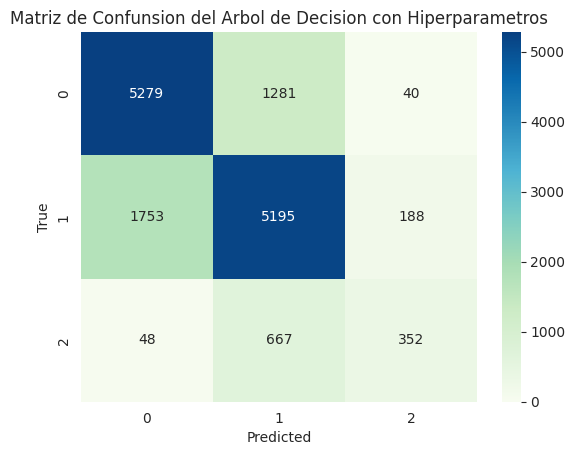

In [ ]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Arbol de Decision con Hiperparametros')

plt.show()

Como hicimos con el Arbol Basico, para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7313382422481929
Recall: 0.7313382422481929
Precision: 0.7267830383993024
f1 score: 0.7256845070074405


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      6600
           1       0.73      0.73      0.73      7136
           2       0.61      0.33      0.43      1067

    accuracy                           0.73     14803
   macro avg       0.69      0.62      0.64     14803
weighted avg       0.73      0.73      0.73     14803



Y ademas medimos importancia de las variables, que se calcula como la reduccion total (normalizada) del criterio aportado por esa caracteristica, tambien conocido como **Gini Importance** o  **Mean Decrease in Impurity** (MDI).

In [ ]:
sorted(list(zip(propiedades_arbol_optimizado_x.columns.to_list(),
                modelo.feature_importances_)), key=lambda x: -x[1])

[('superficie_total', 0.2500661054427032),
 ('tipo_Departamento', 0.186998912039762),
 ('superficie_cubierta', 0.18151634106710768),
 ('barrio_Palermo', 0.06148094211035632),
 ('barrio_Puerto Madero', 0.04802429151882249),
 ('barrio_Belgrano', 0.04659149606862742),
 ('barrio_Recoleta', 0.04446580944292568),
 ('ambientes', 0.035735168582147606),
 ('barrio_Nuñez', 0.024489198867879272),
 ('barrio_Balvanera', 0.017798585371670887),
 ('barrio_Villa Urquiza', 0.015530256844422845),
 ('dormitorios', 0.015368632167678989),
 ('tipo_PH', 0.013780903900118576),
 ('barrio_Caballito', 0.012498958931196739),
 ('barrio_Colegiales', 0.010906628252257303),
 ('barrio_Saavedra', 0.005768974389774453),
 ('barrio_Coghlan', 0.0055969156751089315),
 ('barrio_Villa Crespo', 0.005137425987802953),
 ('barrio_Villa Devoto', 0.0050680365705152225),
 ('barrio_Retiro', 0.004305274468624402),
 ('barrio_Almagro', 0.0033035346856614355),
 ('barrio_Chacarita', 0.003000912119346728),
 ('barrio_Constitución', 0.00095863

Con este array de **Gini Importance**, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de *superficie_total*
2.   Si la propiedad es un Departamento
3.   Su cantidad de *superficie_cubierta*
4.   Si la propiedad es del *barrio* Palermo
5.   Si la propiedad es del *barrio* Puerto Madero

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

##### Grafico del Arbol

Para terminar, graficamos el nuevo Arbol obtenido con los hiperparametros calculados. Cabe destacar que, por la cantidad de registros, el Arbol completo tarda demasiado en correr y ademas no se visualiza bien, por lo que solo graficamos una parte.

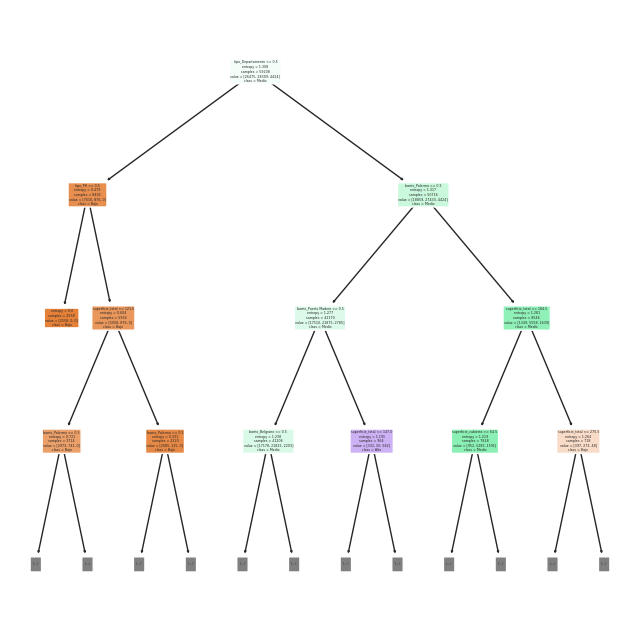

In [ ]:
plt.figure(figsize = (8, 8))

tree_plot = tree.plot_tree(modelo,
                           max_depth = 3,
                           feature_names = propiedades_arbol_optimizado_x.columns.to_list(),
                           filled = True,
                           rounded = True,
                           class_names = ['Bajo','Medio','Alto'])

plt.show(tree_plot)

#### Conclusion del Modelo

Nuestra conclusion sobre la clasificacion mediante Arboles de Decisión es que fue muy dificil hasta casi improbable, mejorar las metricas generadas por el modelo creado de forma default. Una vez utilizado el **Random Search CV** y seleccionando 20 folds, logramos encontrar un combinacion de hiperparametros, los cuales casi ni modifican las metricas (lo reducen pero en una medida infima).

 Entonces concluimos que por estar trabajando con big data, los arboles no son tan buenos predictores para este caso, siendo el arbol 100% default uno de los mejores, o quizas el mejor.

### Random Forest

Para predecir la variable *tipo_precio* con Random Forest, utilizamos la misma metodologia que en Arboles de Decision:

1.   Realizamos un preprocesamiento inicial sobre el dataframe.
2.   Dividimos el dataframe en train-test, creamos el modelo y lo entrenamos.
3.   Mostramos las metricas, la matriz de confusion, y la importancia de sus variables.
4.   Graficamos el modelo o una porción representativa del mismo, en caso de ser muy grande.

#### Random Forest Basico

##### Preprocesamiento

Primero, eliminamos varias columnas que consideramos irrelevantes o en su defecto, tienen información directamente relacionada a *tipo_precio*.

In [150]:
columnas_eliminar = ['precio', 'pxm2', 'id', 'fecha_inicio', 'fecha_fin', 'latitud', 'longitud', 'nombre']
propiedades_rf = propiedades.drop(columnas_eliminar, axis='columns', inplace=False)

propiedades_rf.columns.tolist()

['barrio',
 'tipo',
 'ambientes',
 'dormitorios',
 'superficie_total',
 'superficie_cubierta',
 'tipo_precio']

Y antes de entrenar el modelo, debemos reconvertir las variables categoricas en numeros.

Primero modificamos el target (la variable a predecir) para que quede en una sola columna pero con valores numericos.

In [151]:
propiedades_rf.replace(to_replace = {'Bajo' : 0, 'Medio' : 1, 'Alto' : 2}, inplace = True)

Y para las otras dos variables categoricas, las transformamos mediante un one hot encoding. Al metodo `get_dummies` podemos pasarle como parámetro `drop_first = True`, pero como es un Random Forest Basico, al igual que en el Arbol Basico al parametro le pasamos False.

In [152]:
propiedades_rf = pd.get_dummies(propiedades_rf, columns=['barrio', 'tipo'], dtype = int)

##### División Train-Test

Realizamos las divisiones con las cuales vamos a entrenar.

In [153]:
propiedades_rf_x = propiedades_rf.drop(['tipo_precio'], axis = 'columns', inplace = False)

propiedades_rf_y = propiedades_rf['tipo_precio'].copy()

x_train, x_test, y_train, y_test = train_test_split(propiedades_rf_x,
                                                    propiedades_rf_y,
                                                    test_size = 0.2,
                                                    random_state = 2)

Creamos el modelo 100% por default para ver sus hiperparametros.

In [154]:
rfc_default = RandomForestClassifier()
rfc_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Ahora creamos un modelo, elegiendo casi todos los hiperparametros por default para probarlo. (Los hiperparametros que se han elegido han sido el max_features que se cambio el default recientemente, el random_state para eliminar la aleatoriedad entre ejecuciones, etc)

In [155]:
rfc = RandomForestClassifier(max_features= 'auto',
                             oob_score=True,
                             random_state=2,
                             n_jobs=-1)

modelo = rfc.fit(X = x_train, y = y_train)

Observamos como predice el modelo

In [156]:
y_pred = modelo.predict(x_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test' , 'pred'])
resultados.head()

,test,pred
0,1,1
1,1,1
2,0,0
3,1,1
4,0,0


##### Metricas y Matriz de Confusion



Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

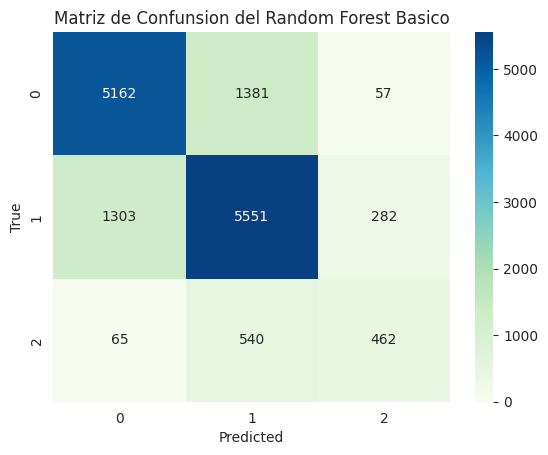

In [157]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Random Forest Basico')

plt.show()

Como hicimos con el Arbol Basico, para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [158]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,  average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7549145443491184
Recall: 0.7549145443491184
Precision: 0.7521544209828916
f1 score: 0.7525926576637594


In [159]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      6600
           1       0.74      0.78      0.76      7136
           2       0.58      0.43      0.49      1067

    accuracy                           0.75     14803
   macro avg       0.70      0.66      0.68     14803
weighted avg       0.75      0.75      0.75     14803



Y ademas medimos importancia de las variables, que se calcula como la reduccion total (normalizada) del criterio aportado por esa caracteristica, tambien conocido como **Gini Importance** o  **Mean Decrease in Impurity** (MDI).

In [ ]:
sorted(list(zip(propiedades_rf_x.columns.to_list(), modelo.feature_importances_)), key=lambda x: -x[1])

[('superficie_total', 0.32654060248963435),
 ('superficie_cubierta', 0.2885350549302758),
 ('tipo_Departamento', 0.048838433817257894),
 ('barrio_Palermo', 0.034666511523911134),
 ('ambientes', 0.034329964187360465),
 ('tipo_PH', 0.03301414786527352),
 ('barrio_Belgrano', 0.021859965479355935),
 ('tipo_Casa', 0.021172687396784667),
 ('barrio_Balvanera', 0.020497274293624204),
 ('barrio_Recoleta', 0.020405613421932877),
 ('barrio_Puerto Madero', 0.020188726329857454),
 ('dormitorios', 0.01895220253807159),
 ('barrio_Nuñez', 0.00931599236289316),
 ('barrio_Villa Urquiza', 0.007896415711257737),
 ('barrio_Flores', 0.006817378988734234),
 ('barrio_Colegiales', 0.005502231400550731),
 ('barrio_Caballito', 0.005008876762779066),
 ('barrio_San Cristobal', 0.0048477863894538465),
 ('barrio_Monserrat', 0.004294115079749226),
 ('barrio_Floresta', 0.004253451170074334),
 ('barrio_San Nicolás', 0.0038744779761441792),
 ('barrio_Villa Lugano', 0.0034142507451049037),
 ('barrio_Almagro', 0.003349701

Con este array de *Gini Importance*, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de *superficie_total* y *superficie_cubierta*
2.   Si la propiedad es un Departamento
3.   Si la propiedad es del barrio Palermo
4.   Su cantidad de Ambientes
5.   Si la propiedad es un PH

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el one hot encoding para reconvertir las variables categóricas. Incluso, algunos numeros tienden a 0 donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

##### Graficamos un arbol del Random Forest

Como Random Forest es un ensamble de arboles trabajados en paralelo, no es posible graficar el bosque entero. Por ello, graficamos uno de los `n_estimators = 100` que son por default (uno de los arboles) como ejemplo.

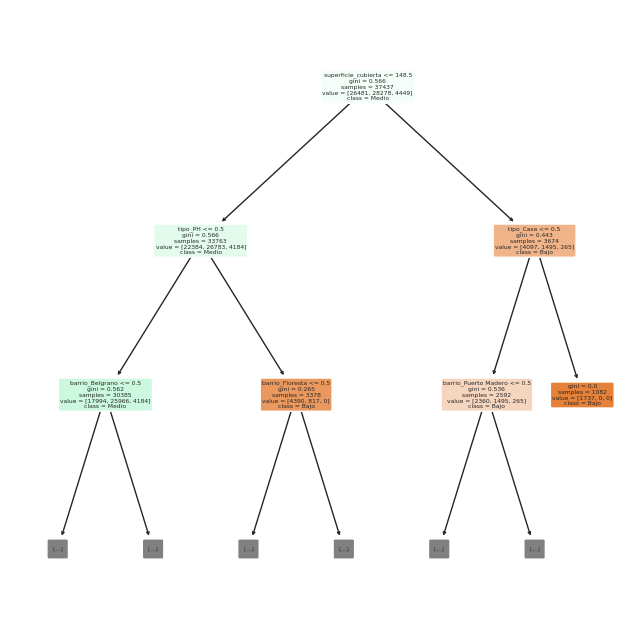

In [160]:
plt.figure(figsize = (8, 8))

tree_plot=tree.plot_tree(modelo.estimators_[68],
                         max_depth = 2,
                         feature_names = propiedades_rf_x.columns.to_list(),
                         filled = True,
                         rounded = True,
                         class_names = ['Bajo', 'Medio', 'Alto'])

plt.show(tree_plot)

####Validación Cruzada

Buscaremos los mejores hiperparametros (seleccionando F1 Score, como la metrica a mejorar), pero esta vez con **Grid Search Cross Validation**.

In [162]:
rf_cv = RandomForestClassifier(max_features = 'auto', oob_score = True, random_state = 2, n_jobs = -1)

parametros = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 4, 8],
               "min_samples_split" : [6, 10, 14],
               "n_estimators" : [30, 50, 70] }

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average = 'weighted')

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator = rf_cv, param_grid = parametros, scoring = scorer_fn, cv = 5, n_jobs = -1)
gs_fit = gs.fit(X = x_train, y = y_train)

Obtenemos la mejor combinacion de hiperparametros.

In [163]:
parametros_seleccionados = gs_fit.best_params_
parametros_seleccionados

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 50}

Vemos cual fue la mejor metrica

In [164]:
print("F1 Score en entrenamiento con CV: "+str(gs_fit.best_score_))

F1 Score en entrenamiento con CV: 0.7470444270359229


Predecimos utilizando el mejor modelo que obtuvimos en entrenamiento

In [165]:
rf_cv_best = gs_fit.best_estimator_

y_pred_rf_cv_best = rf_cv_best.predict(x_test)

Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

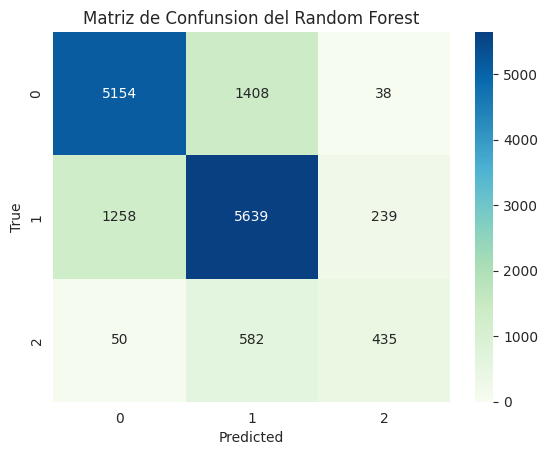

In [166]:
tabla = confusion_matrix(y_test, y_pred_rf_cv_best)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confunsion del Random Forest')

plt.show()

Como hicimos con el Arbol Basico, para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

Por las dudas, volvemos a la dejar la documentacion encontrada sobre algunos posibilidades del parametro `average`:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [167]:
accuracy = accuracy_score(y_test, y_pred_rf_cv_best)
recall = recall_score(y_test, y_pred_rf_cv_best,  average = 'weighted')
f1 = f1_score(y_test, y_pred_rf_cv_best, average = 'weighted')
precision = precision_score(y_test, y_pred_rf_cv_best, average = 'weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7584948996824968
Recall: 0.7584948996824968
Precision: 0.7559652336947381
f1 score: 0.7553179390710802


In [168]:
print(classification_report(y_test,y_pred_rf_cv_best))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      6600
           1       0.74      0.79      0.76      7136
           2       0.61      0.41      0.49      1067

    accuracy                           0.76     14803
   macro avg       0.72      0.66      0.68     14803
weighted avg       0.76      0.76      0.76     14803



Tambien podriamos optimizar hiperparametros teniendo en cuenta mas de una sola metrica. Asi que, ahora buscamos los mejores hiperparametros seleccionando Accuracy, F1 Score, como las metricas a mejorar. Esta optimizacion, se hara tambien con **Grid Search Cross Validation**.

In [172]:
rf_cv = RandomForestClassifier(max_features = 'auto', oob_score = True, random_state = 1, n_jobs = -1)

parametros = { "criterion" : ["gini", "entropy"],
               "min_samples_leaf" : [1, 5, 10],
               "min_samples_split" : [2, 4, 10, 16],
               "n_estimators": [10, 20, 50] }

metricas = {'accuracy' : make_scorer(accuracy_score),
            'f1' : make_scorer(f1_score, average = 'weighted')}

gs_multimetrica = GridSearchCV(estimator = rf_cv,
                               parametros_seleccionados = parametros,
                               scoring = metricas,
                               refit = False,
                               cv = 5,
                               n_jobs = -1)

gs_multimetrica_fit = gs_multimetrica.fit(X = x_train, y = y_train)

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'parametros_seleccionados'

Realizamos un grafico sobre los resultados de las metricas.

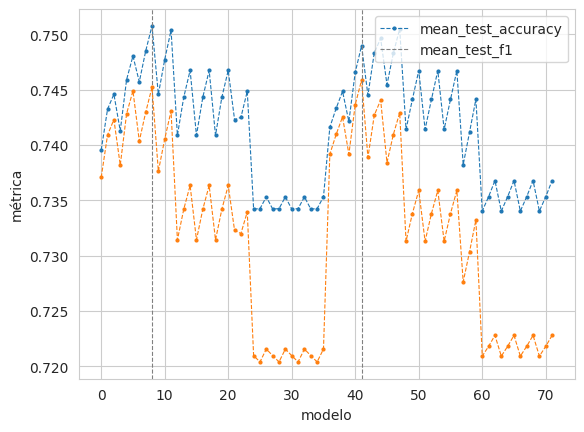

In [ ]:
labels=[ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)
    x_linea=np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')

plt.xlabel("Modelo", fontsize=10)
plt.ylabel("Métrica", fontsize=10)
plt.legend(labels)
plt.show()

En el gráfico podemos observar como hay 2 modelos (los de la linea punteada en gris), los cuales llegan a las mejores métricas tanto de Accuracy como de F1, en conjunto. Ellos son el modelo num 8 y el modelo num 41.

Sin embargo, también podríamos elegir un modelo que maximice una de las dos métricas en particular.

Casualmente, el modelo que maximiza la Accuracy, es justamente el modelo 8

In [ ]:
params_max_accuracy=gs_multimetrica_fit.cv_results_['params'][8]#[np.argmax(gs_multimetrica_fit.cv_results_['mean_test_accuracy'])]
params_max_accuracy

{'criterion': 'gini',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50}

Y paradójicamente, también el modelo que maximiza el F1 Score, es justamente el modelo 41

In [ ]:
params_max_f1=gs_multimetrica_fit.cv_results_['params'][41]#[np.argmax(gs_multimetrica_fit.cv_results_['mean_test_f1'])]
params_max_f1

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50}

De estos 3 modelos con hiperparametros optimizados (los 2 aqui arriba presentes y el anterior CV hecho con una sola métrica a mejorar), deberemos seleccionar uno para crear nuestro Random Forest Optimizado. Notamos que el mejor de los 3, analizando todas sus métricas, fue el primero. El Grid Search CV eligiendo el F1 Score como la métrica a mejorar.

A continuación, predeciremos utilizando el modelo seleccionado de los tres diferentes que obtuvimos en entrenamiento.

####Random Forest (Con Optimizaciones Encontradas)

Creamos el modelo elegiendo los mejores hiperparametros propuestos para el mismo, segun el Grid Search Cross Validation

In [ ]:
#Creamos un clasificador RF
rfc_multimetrica = RandomForestClassifier(criterion = parametros_seleccionados['criterion'],
                                          min_samples_leaf = parametros_seleccionados['min_samples_leaf'],
                                          min_samples_split = parametros_seleccionados['min_samples_split'],
                                          n_estimators = parametros_seleccionados['n_estimators'],
                                          oob_score=True, random_state=2, n_jobs=-1)
#Entrenamos un modelo
model_rfc_multimetrica = rfc_multimetrica.fit(X = x_train, y = y_train)

#Hacemos una predicción
y_pred_model_rfc_multimetrica = model_rfc_multimetrica.predict(x_test)

Grafiquemos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

Text(50.722222222222214, 0.5, 'True')

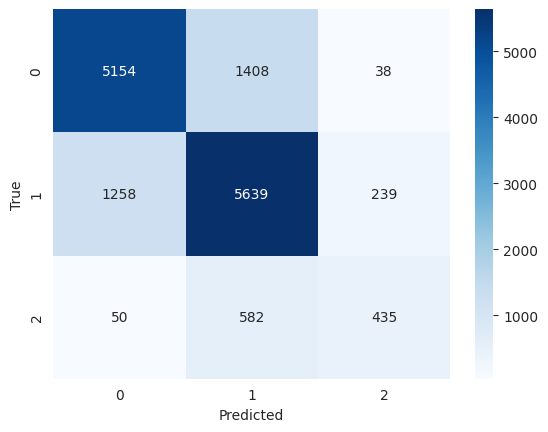

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred_model_rfc_multimetrica)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Calculamos las métricas en el conjunto de evaluación y las imprimimos. Sin embargo, como mi dato a predecir es multiclase no es binario. Por ende, la métricas necesitan saber cómo calcularse cuando hay más de dos clases en los datos.

Habiendo investigado en la correspondiente documentación, las opciones disponibles para el parámetro average, por ejemplo, en el recall son:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [ ]:
accuracy=accuracy_score(y_test,y_pred_model_rfc_multimetrica)
recall=recall_score(y_test,y_pred_model_rfc_multimetrica, average='weighted')
f1=f1_score(y_test,y_pred_model_rfc_multimetrica,average='weighted')
precision=precision_score(y_test,y_pred_model_rfc_multimetrica,average='weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7584948996824968
Recall: 0.7584948996824968
Precision: 0.7559652336947381
f1 score: 0.7553179390710802


In [ ]:
#Reporte
print(classification_report(y_test,y_pred_model_rfc_multimetrica))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      6600
           1       0.74      0.79      0.76      7136
           2       0.61      0.41      0.49      1067

    accuracy                           0.76     14803
   macro avg       0.72      0.66      0.68     14803
weighted avg       0.76      0.76      0.76     14803



**Importancia de los Features**

La importancia de una característica se calcula como la reducción total (normalizada) del criterio aportado por esa característica.
También se conoce como *Gini Importance* o tambien, *Mean Decrease in Impurity* (MDI).

In [ ]:
sorted(list(zip(propiedades_rf_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('superficie_total', 0.32654060248963435),
 ('superficie_cubierta', 0.2885350549302758),
 ('tipo_Departamento', 0.048838433817257894),
 ('barrio_Palermo', 0.034666511523911134),
 ('ambientes', 0.034329964187360465),
 ('tipo_PH', 0.03301414786527352),
 ('barrio_Belgrano', 0.021859965479355935),
 ('tipo_Casa', 0.021172687396784667),
 ('barrio_Balvanera', 0.020497274293624204),
 ('barrio_Recoleta', 0.020405613421932877),
 ('barrio_Puerto Madero', 0.020188726329857454),
 ('dormitorios', 0.01895220253807159),
 ('barrio_Nuñez', 0.00931599236289316),
 ('barrio_Villa Urquiza', 0.007896415711257737),
 ('barrio_Flores', 0.006817378988734234),
 ('barrio_Colegiales', 0.005502231400550731),
 ('barrio_Caballito', 0.005008876762779066),
 ('barrio_San Cristobal', 0.0048477863894538465),
 ('barrio_Monserrat', 0.004294115079749226),
 ('barrio_Floresta', 0.004253451170074334),
 ('barrio_San Nicolás', 0.0038744779761441792),
 ('barrio_Villa Lugano', 0.0034142507451049037),
 ('barrio_Almagro', 0.003349701

Con este array de *Gini Importance*, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de Superficie Total y Superficie Cubierta
2.   Si la propiedad es un Departamento
3.   Si la propiedad es del barrio Palermo
4.   Su cantidad de Ambientes
5.   Si la propiedad es un PH

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el *get_dummies* para hot codear una reconversión de las variables categóricas. Incluso, algunos números tienden a 0 (cero), donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.

**Grafiquemos un árbol del Random Forest**

Como Random Forest es un ensamble de arboles trabajados en paralelo, no es posible graficar el bosque entero. Por ello, graficamos uno de los n_estimators=50 que son por default (uno de los arboles) como ejemplo.

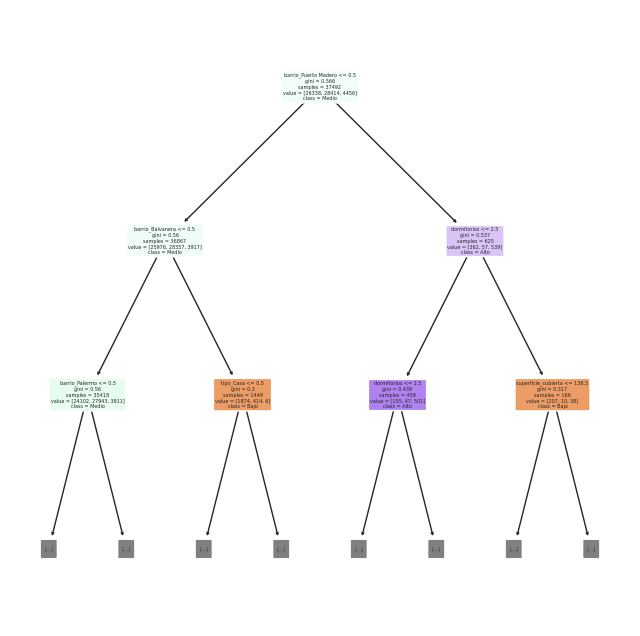

In [ ]:
plt.figure(figsize=(8,8))

tree_plot=tree.plot_tree(model.estimators_[7],
                         max_depth=2,
                         feature_names=propiedades_rf_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names = ['Bajo','Medio', 'Alto']) #model.classes_

plt.show(tree_plot)

Nuestra conclusión sobre Clasificación mediante Random Forest es la siguiente. Fue dificil mejorar las métricas generadas por el modelo creado de forma default. sin embargo, utilizando el Grid Search CV y seleccionando F1 Score como la métrica a mejorar, hemos logrado encontrar un combinación de hiperparametros, los cuales mejoran las métricas aunque en una medida ínfima. De esta manera, hemos llegado a la conclusión de que como los bosques utilizan muchos árboles en paralelo y al estar trabajando con big data, también los Random Forest no son tan buenos predictores para clasificar, en este caso. Mencionando que el mejor bosque supera las métricas del mejor árbol, en una baja medida.

### Modelo a Eleccion (XGBoost)

In [ ]:
columnas_eliminar = ['precio', 'pxm2', 'id', 'fecha_inicio', 'fecha_fin', 'latitud', 'longitud', 'nombre']
propiedades_xgb = propiedades.drop(columnas_eliminar, axis='columns', inplace=False)

propiedades_xgb.columns.tolist()

['barrio',
 'tipo',
 'ambientes',
 'dormitorios',
 'superficie_total',
 'superficie_cubierta',
 'tipo_precio']

In [ ]:
propiedades_xgb.replace(to_replace={'Bajo': 0, 'Medio': 1, 'Alto': 2}, inplace=True)

In [ ]:
propiedades_xgb = pd.get_dummies(propiedades_xgb, columns=['barrio', 'tipo'], dtype = int)#, drop_first=True)

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
propiedades_xgb_x = propiedades_xgb.drop(['tipo_precio'], axis='columns', inplace=False)

#Creo un dataset con la variable target
propiedades_xgb_y = propiedades_xgb['tipo_precio'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(propiedades_xgb_x,
                                                    propiedades_xgb_y,
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=2) #semilla

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

xgb_default = xgb.XGBClassifier()
xgb_default.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
#Creo el modelo y lo entreno

xgb = xgb.XGBClassifier(random_state=0, n_estimators=100)
modelo = xgb.fit(x_train, y_train)

In [ ]:
#Realizamos una predicción sobre el set de test
y_pred = modelo.predict(x_test)
#Valores Predichos
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
#Valores Reales
y_test.values

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
resultados.head()

,test,pred
0,1,1
1,1,1
2,0,1
3,1,1
4,0,0


Grafiquemos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *tipo_precio* son:

*   0 = Bajo
*   1 = Medio
*   2 = Alto

Text(50.722222222222214, 0.5, 'True')

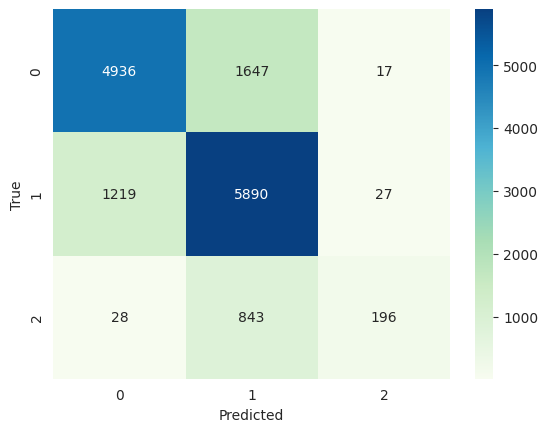

In [ ]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Calculamos las métricas en el conjunto de evaluación y las imprimimos.
Sin embargo, como mi dato a predecir es multiclase no es binario. Por ende, la métricas necesitan saber cómo calcularse cuando hay más de dos clases en los datos.

Habiendo investigado en la correspondiente documentación, las opciones disponibles para el parámetro average, por ejemplo, en el recall son:

*   None: Devuelve un arreglo que contiene el recall de cada clase.
*   macro: Calcula el recall por clase y luego toma el promedio no ponderado.
*   weighted: Calcula el recall por clase y luego toma el promedio ponderado por el soporte de cada clase.

In [ ]:
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred, average='weighted')
f1=f1_score(y_test,y_pred,average='weighted')
precision=precision_score(y_test,y_pred,average='weighted')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7445788015942715
Recall: 0.7445788015942715
Precision: 0.7536255595320525
f1 score: 0.7319330748834587


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      6600
           1       0.70      0.83      0.76      7136
           2       0.82      0.18      0.30      1067

    accuracy                           0.74     14803
   macro avg       0.77      0.59      0.61     14803
weighted avg       0.75      0.74      0.73     14803



**Importancia de los Features**

La importancia de una característica se calcula como la reducción total (normalizada) del criterio aportado por esa característica.
También se conoce como *Gini Importance* o tambien, *Mean Decrease in Impurity* (MDI).

In [ ]:
sorted(list(zip(propiedades_xgb_x.columns.to_list(), modelo.feature_importances_)), key=lambda x: -x[1])

[('tipo_Departamento', 0.15782486),
 ('barrio_Puerto Madero', 0.10268029),
 ('barrio_Balvanera', 0.069130525),
 ('barrio_Palermo', 0.06512538),
 ('barrio_Belgrano', 0.062506035),
 ('barrio_Recoleta', 0.048558522),
 ('barrio_Nuñez', 0.04178523),
 ('barrio_Villa Urquiza', 0.031095954),
 ('barrio_Flores', 0.022164876),
 ('barrio_Villa Lugano', 0.021365909),
 ('tipo_Casa', 0.021225616),
 ('barrio_Colegiales', 0.020338276),
 ('barrio_Caballito', 0.019266762),
 ('barrio_San Cristobal', 0.018963594),
 ('barrio_Monserrat', 0.018338006),
 ('barrio_San Nicolás', 0.017721437),
 ('barrio_Constitución', 0.017712897),
 ('barrio_Boca', 0.017645193),
 ('barrio_Floresta', 0.017365528),
 ('barrio_Boedo', 0.012889169),
 ('barrio_Coghlan', 0.012607458),
 ('barrio_Saavedra', 0.011893191),
 ('barrio_Parque Avellaneda', 0.011129483),
 ('barrio_Mataderos', 0.011030157),
 ('barrio_Villa Devoto', 0.009177343),
 ('barrio_Parque Patricios', 0.009151813),
 ('barrio_Pompeya', 0.008565181),
 ('barrio_Villa Crespo', 

Con este array de *Gini Importance*, claramente observamos como los features mas importantes de las propiedades son:

1.   Su cantidad de Superficie Total y Superficie Cubierta
2.   Si la propiedad es del barrio Palermo
3.   Si la propiedad es un Departamento o PH
4.   Si la propiedad es del barrio Puerto Madero
5.   Si la propiedad es una Casa
6.   Si la propiedad es del barrio Belgrano
7.   Su cantidad de Ambientes

Aunque de todas formas, sus coeficientes son bastante bajos por la cantidad de features que se generaron a la hora de hacer el *get_dummies* para hot codear una reconversión de las variables categóricas. Incluso, algunos números llegan a ser igual a 0 (cero), donde, intuitivamente por la cantidad que son, notamos que muchos son barrios.